In [1]:
import sys
sys.version


'3.9.0 (v3.9.0:9cf6752276, Oct  5 2020, 11:29:23) \n[Clang 6.0 (clang-600.0.57)]'

In [2]:
from neuralprophet import NeuralProphet
from util_func import preprocess_time_series

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install arviz
import arviz as az

In [4]:
# Specify the path to your CSV file
csv_file_path = "data/ts1.csv"  # Update this with the actual path to your CSV file

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df)

      crn     date  stime  etime  itype  depth      chl    phaeo       l12  \
0       #   yymmdd   hhmm   hhmm             m    mg/m3    mg/m3   mg C/m3   
1       1   881031     -9     -9      0     24    0.129    0.077    12.210   
2       1   881031     -9     -9      0     42    0.192    0.051     2.470   
3       1   881031     -9     -9      0     68    0.285    0.303     2.580   
4       1   881031     -9     -9      0    114    0.326    0.044     0.720   
...   ...      ...    ...    ...    ...    ...      ...      ...       ...   
2585  339   220901    443   1948      2     75    0.180    0.227    -9.000   
2586  339   220901    443   1948      2    100    0.208    0.578    -9.000   
2587  339   220901    443   1948      2    125    0.130    0.418    -9.000   
2588  339   220901    443   1948      2    150    0.076    0.310    -9.000   
2589  339   220901    443   1948      2    175    0.038    0.128    -9.000   

           d12      bsal     pbact     hbact     sbact     ebac

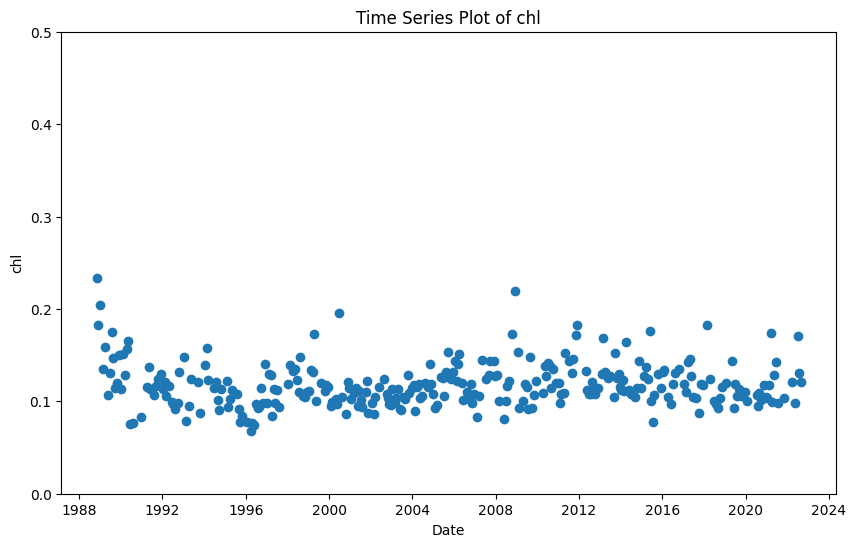

In [5]:
# Convert 'data' column to datetime format
df[' date'] = pd.to_datetime(df[' date'][1:], format=' %y%m%d')

# Clean and convert 'chl' column to numeric values
df[' chl'] = df[' chl'].apply(lambda x: pd.to_numeric(x.split(), errors='coerce').mean())

# Calculate the mean for each date
df_chl = df.groupby(' date', dropna=True)[' chl'].mean().reset_index()


## Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_chl[' date'], df_chl[' chl'], marker='o', linestyle='')
plt.title('Time Series Plot of chl')
plt.xlabel('Date')
plt.ylabel('chl')
plt.ylim([0 , 0.5])
#plt.grid(True)
plt.show()

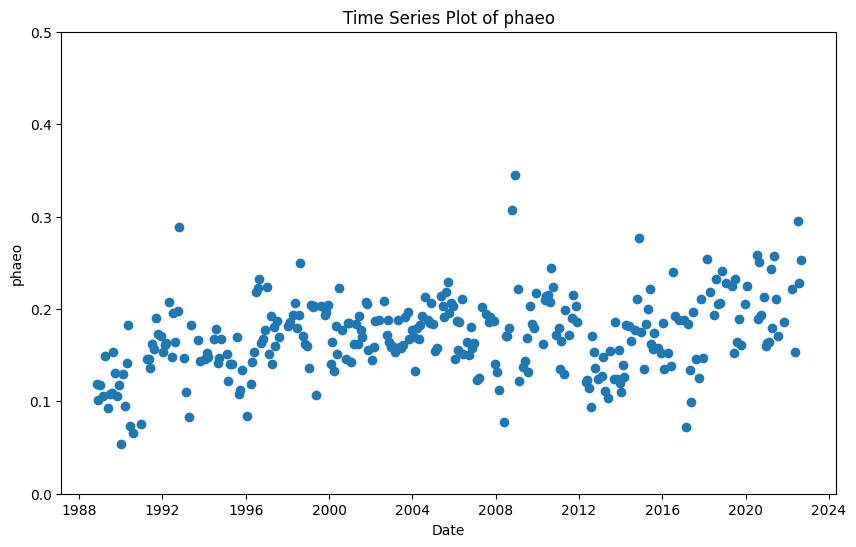

In [6]:
# Clean and convert 'chl' column to numeric values
df[' phaeo'] = df[' phaeo'].apply(lambda x: pd.to_numeric(x.split(), errors='coerce').mean())

# Calculate the mean for each date
df_phaeo = df.groupby(' date', dropna=True)[' phaeo'].mean().reset_index()

## Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_phaeo[' date'], df_phaeo[' phaeo'], marker='o', linestyle='')
plt.title('Time Series Plot of phaeo')
plt.xlabel('Date')
plt.ylabel('phaeo')
plt.ylim([0 , 0.5])
#plt.grid(True)
plt.show()

In [7]:
# Rename the 'date' column to 'ds'
df_chl.rename(columns={' date': 'ds'}, inplace=True)
df_chl.rename(columns={' chl': 'y'}, inplace=True)

In [8]:
# Create a NeuralProphet model with default parameters
from neuralprophet import NeuralProphet, set_log_level
m = NeuralProphet()

In [9]:
df_given = pd.read_csv('./data_given.csv')

In [10]:
# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_given)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 173
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (23) is too small than the required number                     for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [11]:
df_future = m.make_future_dataframe(df_given, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 23it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


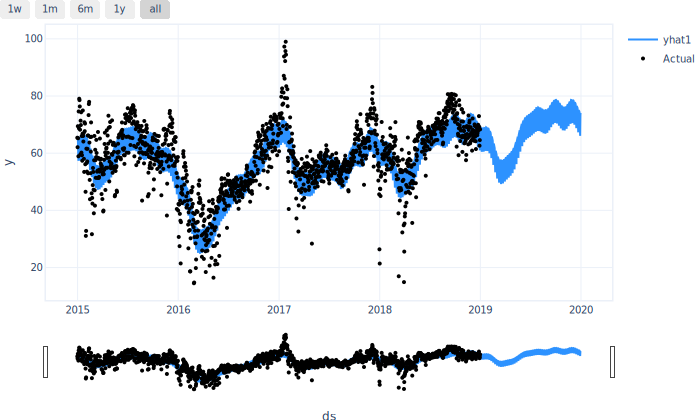

In [12]:
m.plot(forecast)

In [13]:
forecast

,ds,y,yhat1,trend,season_yearly,season_weekly
0,2014-12-31,65.41,65.567223,62.914032,0.750135,1.903051
1,2015-01-01,62.09,65.571205,62.944153,0.636270,1.990782
2,2015-01-02,69.44,65.159264,62.974266,0.535733,1.649264
3,2015-01-03,65.22,60.357040,63.004379,0.449127,-3.096471
4,2015-01-04,58.91,57.323387,63.034492,0.375935,-6.087044
...,...,...,...,...,...,...
1822,2019-12-27,NaN,74.114594,71.081779,1.380400,1.652414
1823,2019-12-28,NaN,69.214035,71.095299,1.212304,-3.093570
1824,2019-12-29,NaN,66.075699,71.108818,1.055596,-6.088717
1825,2019-12-30,NaN,73.551842,71.122337,0.911845,1.517662


In [14]:
!pip list

Package                   Version
------------------------- ------------
absl-py                   2.0.0
aiohttp                   3.8.6
aiosignal                 1.3.1
ansi2html                 1.8.0
anyio                     4.0.0
appnope                   0.1.3
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
arviz                     0.16.1
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     23.1.0
Babel                     2.13.1
beautifulsoup4            4.12.2
bleach                    6.1.0
blinker                   1.7.0
cachetools                5.3.2
captum                    0.6.0
certifi                   2023.7.22
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
comm                      0.2.0
contourpy                 1.2.0
cycler                    0.12.1
dash                      2.14.1
dash-core-componen

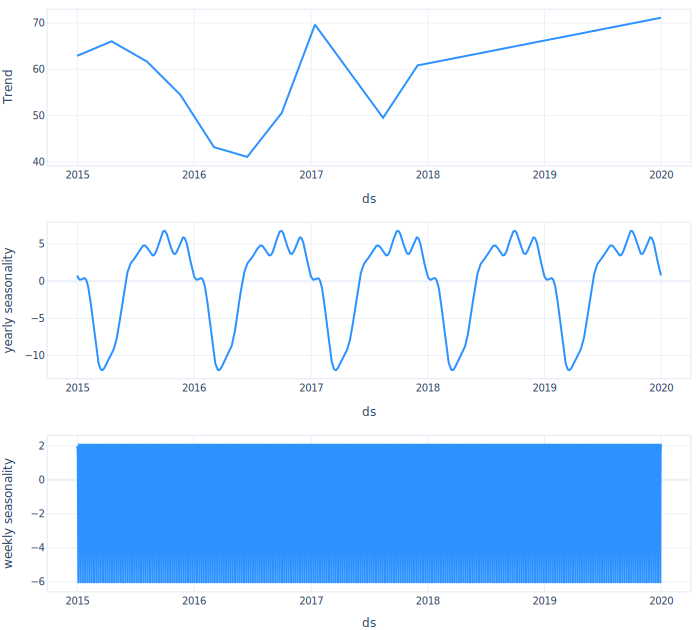

In [15]:
m.plot_components(forecast) 

In [41]:
m2 = NeuralProphet()
m2.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m2.fit(df_resampled)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.755]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 266
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number                     for the learning rate finder

Finding best initial lr:   0%|          | 0/217 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [44]:
metrics = m2.fit(df_resampled)

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.755]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
ERROR - (NP.forecaster.fit) - Model has already been fitted. Re-fitting may break or produce different results.


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

In [42]:
df_future = m.make_future_dataframe(df_given, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 23it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


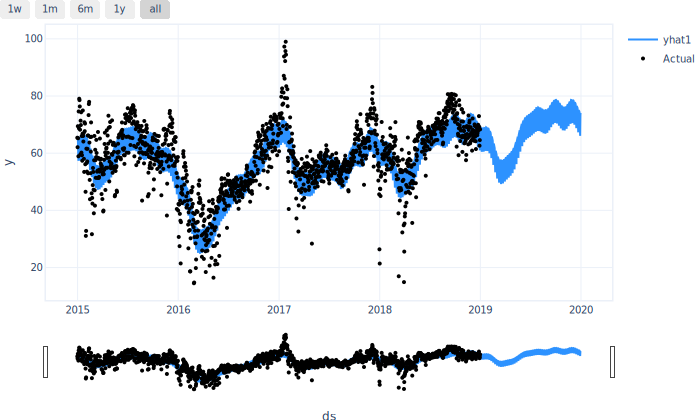

In [43]:
m.plot(forecast)

In [45]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,6.356238,6.707967,1.711124,0.0,0
1,5.794218,6.149991,1.549587,0.0,1
2,5.259239,5.601212,1.395774,0.0,2
3,4.715076,5.051949,1.240275,0.0,3
4,4.143861,4.473049,1.075036,0.0,4
...,...,...,...,...,...
261,0.103975,0.180938,0.004980,0.0,261
262,0.103953,0.180693,0.004977,0.0,262
263,0.104539,0.183303,0.005067,0.0,263
264,0.103406,0.180217,0.004976,0.0,264


KeyError: 'ds'

In [31]:
df_chl

,y
ds,
1988-10-31,0.233000
1988-12-02,0.182500
1989-01-08,0.204750
1989-02-28,0.135500
1989-03-27,0.158250
...,...
2022-03-27,0.120875
2022-05-26,0.098250
2022-07-09,0.170750


In [35]:
df_phaeo.columns

Index([' date', ' phaeo'], dtype='object')

In [38]:
df_phaeo.rename(columns={' date': 'ds'}, inplace=True)
df_phaeo.rename(columns={' phaeo': 'y'}, inplace=True)
df_phaeo.columns

Index(['ds', 'y'], dtype='object')

In [39]:
df_resampled = preprocess_time_series(df_phaeo, date_column='ds', value_column='y', target_frequency='M', aggregation_function='sum', fillna_value=0)

In [46]:
df_resampled

,ds,y
0,1988-10-31,0.118750
1,1988-11-30,0.000000
2,1988-12-31,0.101625
3,1989-01-31,0.117375
4,1989-02-28,0.105625
...,...,...
403,2022-05-31,0.153000
404,2022-06-30,0.000000
405,2022-07-31,0.522625
406,2022-08-31,0.000000


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.755]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 266
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number                     for the learning rate finder

Finding best initial lr:   0%|          | 0/217 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.755]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.772]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.772]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.data.processing._handle_missing_data) - Dropped 30 rows at the end with NaNs in 'y' column.


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


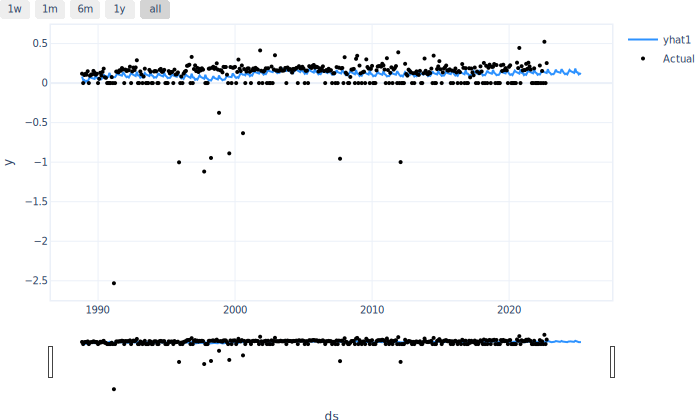

In [48]:
m = NeuralProphet()
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(df_resampled)


df_future = m.make_future_dataframe(df_resampled, n_historic_predictions=True, periods=30)

# Predict the future
forecast = m.predict(df_future)

m.plot(forecast)